# Quarterly RUB Pipeline (Helper-Driven)

Shared helpers now discover raw CSVs from ticker lists, align prices directly to quarters, and package a publishable RUB return panel with diagnostics-ready structures.

## Setup

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

from helpers import (
    set_style,
    styled_table,
    prepare_returns_dataset,
    exp_weights,
    weighted_mean_cov,
    nearest_psd,
    jb_test,
    shapiro_test,
    ljung_box,
    plot_correlation_heatmap,
    plot_acf_grid,
    plot_rolling_stats,
    plot_drawdowns,
    split_crypto_noncrypto,
    compute_ledoit_wolf,
)

set_style()

FREQUENCY = "Q"
BASE_CURRENCY = "RUB"
ANNUALIZATION_FACTOR = 4  # quarters per year
HALF_LIFE_MEAN = 8        # emphasise ~2 years
HALF_LIFE_COV = 4         # emphasise ~1 year
WINSOR_ALPHA = 0.01

FOCUS_TICKERS = ["GC-F", "BTC-USD", "SOL-USD", "SPY", "IEF", "SBGB", "SBMX"]

dataset = prepare_returns_dataset(
    FOCUS_TICKERS,
    frequency=FREQUENCY,
    base_currency=BASE_CURRENCY,
    winsor_alpha=WINSOR_ALPHA,
)

catalog = dataset["catalog"]
fx_quarterly = dataset["fx"]
returns_long = dataset["returns_long"]
returns_aligned = dataset["aligned"]
q_matrix_log = dataset["matrix_log"]
q_matrix_simple = dataset["matrix_simple"]

print(f"Aligned quarterly matrix shape: {q_matrix_log.shape}")



Aligned quarterly matrix shape: (22, 6)


## Universe Overview

In [2]:
catalog_view = catalog.set_index("asset_id")
display(styled_table(catalog_view, caption="Asset universe (metadata discovered from disk)"))



,category,asset_type,asset_ccy,path
asset_id,,,,
GC-F,commodities,Commodity future,USD,C:\Users\koles\Desktop\finance_programs\data\c...
BTC-USD,crypto,Crypto asset,USD,C:\Users\koles\Desktop\finance_programs\data\c...
SOL-USD,crypto,Crypto asset,USD,C:\Users\koles\Desktop\finance_programs\data\c...
SPY,sp500_index,US equity ETF,USD,C:\Users\koles\Desktop\finance_programs\data\s...
IEF,us_bonds,US Treasury ETF,USD,C:\Users\koles\Desktop\finance_programs\data\u...
SBGB,ru_bonds,RU bond ETF,RUB,C:\Users\koles\Desktop\finance_programs\data\r...


## Quarterly FX And Returns Snapshot

In [3]:
print("Recent FX behaviour and sample asset returns (winsorised log RUB).")
fx_tail = fx_quarterly.tail().set_index("date")
display(styled_table(fx_tail, caption="USD/RUB quarterly tail", precision=4))

preview = (
    returns_aligned
    .loc[returns_aligned["asset_id"].isin(["BTC-USD", "SBGB"]),
         ["asset_id", "date", "price_local", "price_base", "r_local_log", "r_fx_log", "r_base_log_w"]]
    .groupby("asset_id")
    .head(6)
    .set_index("date")
)
display(styled_table(preview, caption="Quarterly returns preview (winsorised log returns)", precision=4))

matrix_tail = q_matrix_log.tail()
display(styled_table(matrix_tail, caption="Quarterly matrix tail (log returns, RUB base)", precision=4))



USD/RUB quarterly tail


,date,fx_rate,r_fx_log,r_fx_simple
99,2024-12-31 23:59:59.999999999,113.4955,0.199212,0.220441
100,2025-03-31 23:59:59.999999999,83.0000,-0.312923,-0.268693
101,2025-06-30 23:59:59.999999999,78.2000,-0.059571,-0.057831
102,2025-09-30 23:59:59.999999999,82.9000,0.058365,0.060102
103,2025-12-31 23:59:59.999999999,79.4983,-0.041899,-0.041034



Quarterly returns preview (winsorised log returns)


,asset_id,date,price_local,price_base,r_local_log,r_fx_log,r_base_log_w
23,BTC-USD,2020-06-30 23:59:59.999999999,9137.993164,6.503820e+05,0.350123,-0.097248,0.252875
24,BTC-USD,2020-09-30 23:59:59.999999999,10784.491211,8.372205e+05,0.165668,0.086859,0.252528
25,BTC-USD,2020-12-31 23:59:59.999999999,29001.720703,2.158079e+06,0.989246,-0.042360,0.946886
26,BTC-USD,2021-03-31 23:59:59.999999999,58918.832031,4.460079e+06,0.708806,0.017142,0.725948
27,BTC-USD,2021-06-30 23:59:59.999999999,35040.835938,2.563314e+06,-0.519647,-0.034219,-0.553865
28,BTC-USD,2021-09-30 23:59:59.999999999,43790.894531,3.185849e+06,0.222912,-0.005494,0.217418
244,SBGB,2020-06-30 23:59:59.999999999,12.410000,1.241000e+01,0.070260,0.000000,0.070260
245,SBGB,2020-09-30 23:59:59.999999999,12.330000,1.233000e+01,-0.006467,0.000000,-0.006467
246,SBGB,2020-12-31 23:59:59.999999999,12.546000,1.254600e+01,0.017367,0.000000,0.017367
247,SBGB,2021-03-31 23:59:59.999999999,12.144000,1.214400e+01,-0.032567,0.000000,-0.032567



Quarterly matrix tail


asset_id,BTC-USD,GC-F,IEF,SBGB,SOL-USD,SPY
date,,,,,,
2024-09-30 23:59:59.999999999,0.093983,0.152574,0.139312,-0.025074,0.124613,0.139725
2024-12-31 23:59:59.999999999,0.588065,0.262602,0.148673,0.103678,0.414416,0.223520
2025-03-31 23:59:59.999999999,-0.436736,-0.151390,-0.272275,0.037964,-0.730204,-0.352663
2025-06-30 23:59:59.999999999,0.201131,-0.007748,-0.046040,0.080000,0.156281,0.042832
2025-09-30 23:59:59.999999999,0.164756,0.080943,0.049561,0.002314,0.110161,0.070613


### FX Behaviour

To keep the currency leg tangible, we track the USD/RUB level alongside its quarterly and rolling annual simple returns. The summary table captures average moves and dispersion across both horizons.

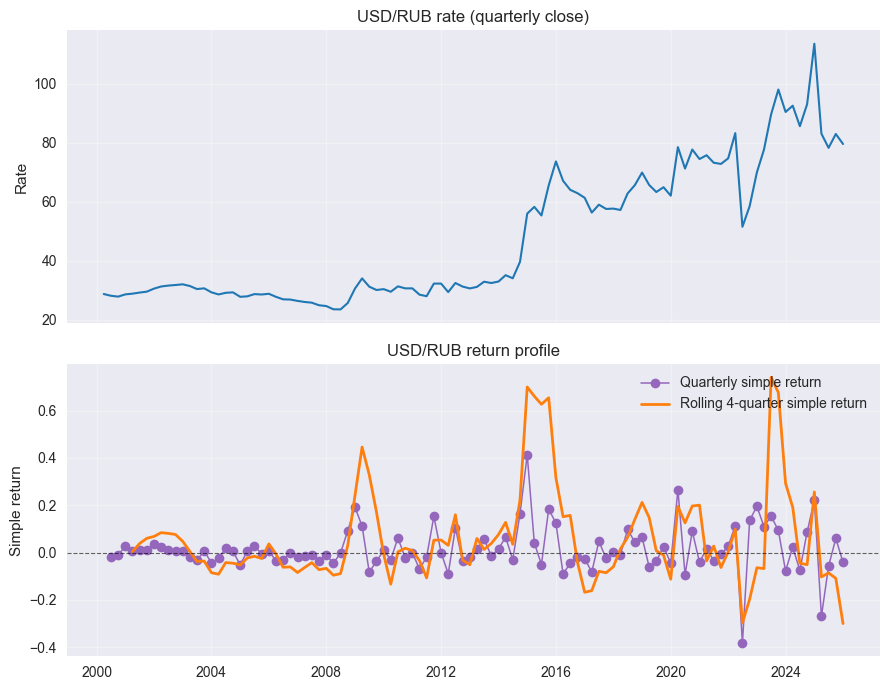

,quarterly_mean_simple,quarterly_sigma_simple,annual_mean_simple,annual_sigma_simple
label,,,,
USD/RUB,0.0144,0.095,0.0562,0.1982


,annual_simple_return
date,
2021,0.003249
2022,-0.063679
2023,0.292704
2024,0.256037
2025,-0.299547


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fx_view = fx_quarterly.sort_values('date').set_index('date')
fx_view['annual_simple_roll'] = (1 + fx_view['r_fx_simple']).rolling(4).apply(lambda r: np.prod(r) - 1, raw=True)

fx_simple = fx_view['r_fx_simple'].dropna()
quarterly_mean = fx_simple.mean()
quarterly_sigma = fx_simple.std(ddof=1)
annual_returns = fx_view['r_fx_simple'].groupby(fx_view.index.year).apply(lambda r: (1 + r).prod() - 1)
annual_mean = annual_returns.mean()
annual_sigma = annual_returns.std(ddof=1)

fig, axes = plt.subplots(2, 1, figsize=(9, 7))
axes[0].plot(fx_view.index, fx_view['fx_rate'], color='tab:blue', linewidth=1.5)
axes[0].set_title('USD/RUB rate (quarterly close)')
axes[0].set_ylabel('Rate')
axes[0].grid(alpha=0.3)

sns.histplot(fx_simple, bins=30, stat='density', color='tab:purple', alpha=0.55, ax=axes[1])
sns.kdeplot(fx_simple, color='tab:blue', linewidth=1.5, ax=axes[1])
axes[1].axvline(quarterly_mean, color='black', linestyle='--', linewidth=1.2, label=f"Mean = {quarterly_mean:.2%}")
axes[1].axvspan(quarterly_mean - quarterly_sigma, quarterly_mean + quarterly_sigma, color='tab:orange', alpha=0.2, label=f"±1σ ({quarterly_sigma:.2%})")
axes[1].set_title('Distribution of quarterly USD/RUB simple returns')
axes[1].set_xlabel('Simple return')
axes[1].set_ylabel('Density')
axes[1].legend(loc='upper left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(
    "Quarterly USD/RUB simple returns: "
    f"mean = {quarterly_mean:.2%}, σ = {quarterly_sigma:.2%}."
)
print(
    "Annual compounded simple returns (calendar years): "
    f"mean = {annual_mean:.2%}, σ = {annual_sigma:.2%}."
)



## Descriptive Statistics

In [5]:
metrics_rows = []
for asset_id, group in returns_long.groupby("asset_id"):
    base_log = group["r_base_log_w"].dropna()
    base_simple = group["r_base_simple_w"].dropna()
    fx_leg = group["r_fx_log"].dropna()
    stats = {
        "asset_id": asset_id,
        "obs": int(len(base_log)),
        "mean_log_quarter": base_log.mean(),
        "mean_simple_quarter": base_simple.mean(),
        "std_simple_quarter": base_simple.std(ddof=1),
        "skew_simple": base_simple.skew(),
        "kurt_excess_simple": base_simple.kurt(),
        "min_simple": base_simple.min(),
        "max_simple": base_simple.max(),
        "autocorr1_simple": base_simple.autocorr(),
    }
    var_base = base_log.var(ddof=1)
    var_fx = fx_leg.var(ddof=1)
    stats["fx_var_share"] = var_fx / var_base if pd.notna(var_base) and var_base != 0 else np.nan
    corr_df = group[["r_local_log", "r_fx_log"]].dropna()
    stats["fx_corr"] = corr_df["r_local_log"].corr(corr_df["r_fx_log"]) if len(corr_df) > 1 else np.nan
    metrics_rows.append(stats)

metrics_df = (pd.DataFrame(metrics_rows)
              .merge(catalog, on="asset_id", how="left")
              .assign(mean_simple_annual=lambda df: np.expm1(df["mean_log_quarter"] * ANNUALIZATION_FACTOR),
                      std_simple_annual=lambda df: df["std_simple_quarter"] * np.sqrt(ANNUALIZATION_FACTOR))
              .set_index("asset_id"))

display(metrics_df.round({
    "mean_log_quarter": 4,
    "mean_simple_quarter": 4,
    "std_simple_quarter": 4,
    "skew_simple": 2,
    "kurt_excess_simple": 2,
    "min_simple": 4,
    "max_simple": 4,
    "autocorr1_simple": 2,
    "fx_var_share": 2,
    "fx_corr": 2,
    "mean_simple_annual": 4,
    "std_simple_annual": 4,
}))

C:\Users\koles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\koles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,obs,mean_log_quarter,mean_simple_quarter,std_simple_quarter,skew_simple,kurt_excess_simple,min_simple,max_simple,autocorr1_simple,fx_var_share,fx_corr,category,asset_type,asset_ccy,path,mean_simple_annual,std_simple_annual
asset_id,,,,,,,,,,,,,,,,,
BTC-USD,44,0.1506,0.2796,0.5822,1.11,0.97,-0.6525,1.9519,-0.06,0.09,0.10,crypto,Crypto asset,USD,C:\Users\koles\Desktop\finance_programs\data\c...,0.8262,1.1643
GC-F,100,0.0392,0.0447,0.1009,0.60,1.37,-0.1921,0.3508,-0.05,1.02,-0.15,commodities,Commodity future,USD,C:\Users\koles\Desktop\finance_programs\data\c...,0.1700,0.2017
IEF,92,0.0206,0.0261,0.1066,1.13,3.33,-0.2556,0.4052,0.02,1.00,0.14,us_bonds,US Treasury ETF,USD,C:\Users\koles\Desktop\finance_programs\data\u...,0.0861,0.2132
SBGB,26,0.0122,0.0137,0.0556,0.45,0.78,-0.1063,0.1548,-0.26,0.00,NaN,ru_bonds,RU bond ETF,RUB,C:\Users\koles\Desktop\finance_programs\data\r...,0.0500,0.1111
SOL-USD,21,0.2537,0.9648,2.2814,2.93,10.10,-0.8032,9.5242,-0.11,0.03,0.22,crypto,Crypto asset,USD,C:\Users\koles\Desktop\finance_programs\data\c...,1.7587,4.5628
SPY,103,0.0304,0.0356,0.0972,-0.35,2.21,-0.2972,0.2851,0.08,0.96,-0.16,sp500_index,US equity ETF,USD,C:\Users\koles\Desktop\finance_programs\data\s...,0.1294,0.1943


### Winsorisation Impact

We compare log-return distributions before and after winsorisation to see which observations were capped and how much the extreme percentiles and variance shifted.

meta                              before                          \
         n_obs winsorised winsorised_share     min     q01     q05     q50   
BTC-USD   44.0        3.0           0.0682 -1.3143 -1.0571 -0.5470  0.1018   
GC-F     100.0        3.0           0.0300 -0.5580 -0.2133 -0.0969  0.0408   
IEF       92.0        3.0           0.0326 -0.5267 -0.2952 -0.0882  0.0007   
SBGB      26.0        3.0           0.1154 -0.1336 -0.1124 -0.0483  0.0067   
SOL-USD   21.0        3.0           0.1429 -1.7759 -1.6258 -1.0253  0.1563   
SPY      103.0        4.0           0.0388 -0.6575 -0.3527 -0.1306  0.0348   

                                 ...           after                          \
            q95     q99     max  ...     var     min     q01     q05     q50   
BTC-USD  0.9246  1.0824  1.1847  ...  0.2208 -1.0571 -0.9105 -0.5470  0.1018   
GC-F     0.1872  0.3007  0.3233  ...  0.0122 -0.2133 -0.2098 -0.0969  0.0408   
IEF      0.1906  0.3402  0.3735  ...  0.0125 -0.2952 -0.2743 -0.0882  0.0007   
SBGB     0.0978  0.1439  0.1573  ...  0.0033 -0.1124 -0.0965 -0.0483  0.0067   
SOL-USD  1.4761  2.3537  2.5731  ...  0.9162 -1.6258 -1.5057 -1.0253  0.1563   
SPY      0.1768  0.2508  0.3926  ...  0.0135 -0.3527 -0.3492 -0.1306  0.0348   

                                                 
            q95     q99     max    mean     var  
BTC-USD  0.9246  1.0242  1.0824  0.1506  0.2001  
GC-F     0.1872  0.3005  0.3007  0.0392  0.0091  
IEF      0.1906  0.3372  0.3402  0.0206  0.0101  
SBGB     0.0978  0.1338  0.1439  0.0122  0.0030  
SOL-USD  1.4761  2.1782  2.3537  0.2537  0.8384  
SPY      0.1768  0.2503  0.2508  0.0304  0.0095  

[6 rows x 21 columns]

,winsorised,winsorised_share,mean_shift,var_reduction
BTC-USD,3.0,0.0682,0.0035,-0.0206
GC-F,3.0,0.0300,0.0032,-0.0031
IEF,3.0,0.0326,0.0022,-0.0024
SBGB,3.0,0.1154,0.0003,-0.0004
SOL-USD,3.0,0.1429,-0.0033,-0.0778
SPY,4.0,0.0388,0.0016,-0.0040


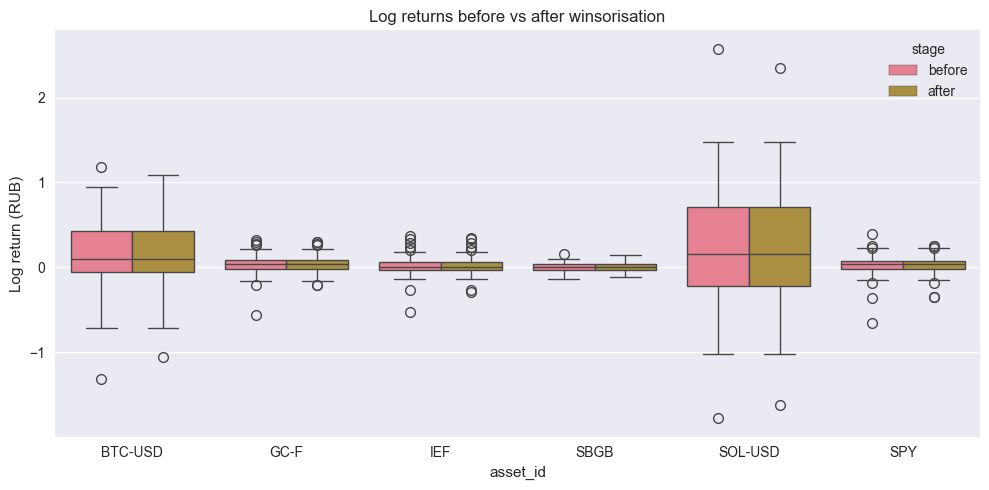

In [6]:
winsor_summary = (
    returns_long
    .groupby('asset_id')[['r_base_log', 'r_base_log_w']]
    .agg(['mean', 'var'])
)
winsor_summary.columns = ['_'.join(col).strip() for col in winsor_summary.columns.values]
winsor_summary = winsor_summary.rename(columns={
    'r_base_log_mean': 'before_mean',
    'r_base_log_var': 'before_var',
    'r_base_log_w_mean': 'after_mean',
    'r_base_log_w_var': 'after_var',
})

winsorised_share = (winsor_summary['after_var'] < winsor_summary['before_var']).mean()

meta = returns_long.drop_duplicates('asset_id').set_index('asset_id')[['asset_type', 'asset_ccy']]
winsor_summary = winsor_summary.join(meta, how='left')

summary_view = winsor_summary[['asset_type', 'asset_ccy', 'before_mean', 'after_mean', 'before_var', 'after_var']].copy()
summary_view['mean_shift'] = summary_view['after_mean'] - summary_view['before_mean']
summary_view['var_reduction'] = summary_view['before_var'] - summary_view['after_var']

display(styled_table(summary_view, caption='Winsorisation impact (log returns, RUB)', precision=5))

print(
    "Share of assets with reduced variance after winsorisation: "
    f"{winsorised_share:.0%}."
)

melted = (
    returns_long[['asset_id', 'r_base_log', 'r_base_log_w']]
    .rename(columns={'r_base_log': 'before', 'r_base_log_w': 'after'})
    .melt(id_vars='asset_id', value_vars=['before', 'after'], var_name='stage', value_name='log_return')
    .dropna()
)
plt.figure(figsize=(10, 5))
sns.boxplot(data=melted, x='asset_id', y='log_return', hue='stage')
plt.title('Log returns before vs after winsorisation')
plt.ylabel('Log return (RUB)')
plt.tight_layout()
plt.show()



## EW μ/Σ And Correlation

,mu_log_quarterly
BTC-USD,0.1313
GC-F,0.0575
IEF,0.0070
SBGB,0.0137
SOL-USD,0.1658
SPY,0.0494


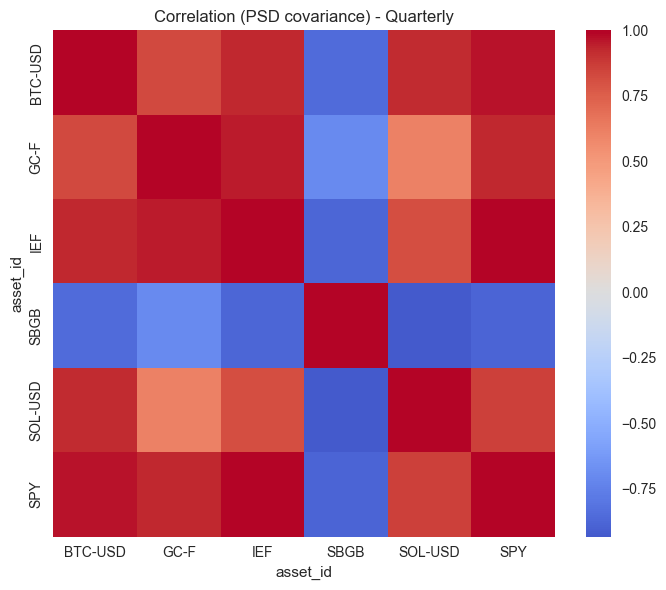

{'smallest_eigenvalue': 0.00047948600931974603, 'condition_number': 1447.7840821058335}
Ledoit-Wolf shrinkage covariance computed on the fully aligned history.


In [7]:
w_mean = exp_weights(q_matrix_log.index, HALF_LIFE_MEAN)
w_cov = exp_weights(q_matrix_log.index, HALF_LIFE_COV)

mu_q, S_q = weighted_mean_cov(q_matrix_log, w_mean)
S_q_psd = nearest_psd(S_q)

display(mu_q.to_frame("mu_log_quarterly").style.format("{:.4f}").set_caption("EW means (quarterly log, RUB)"))
plot_correlation_heatmap(S_q_psd, title="Correlation (PSD covariance) - Quarterly")

eigvals = np.linalg.eigvalsh(S_q_psd.to_numpy())
condition_number = float(eigvals.max() / max(eigvals.min(), 1e-12))
print({"smallest_eigenvalue": float(eigvals.min()), "condition_number": condition_number})

ledoit = compute_ledoit_wolf(q_matrix_log)
if ledoit is not None:
    print("Ledoit-Wolf shrinkage covariance computed on the fully aligned history.")

## Distribution Checks

In [8]:
tests = []
for asset in q_matrix_log.columns:
    series = q_matrix_log[asset].dropna()
    if len(series) < 8:
        continue
    jb_stat, jb_p = jb_test(series)
    sh_stat, sh_p = shapiro_test(series)
    tests.append({
        'asset_id': asset,
        'mean_quarter': series.mean(),
        'stdev_quarter': series.std(ddof=1),
        'skew': series.skew(),
        'excess_kurtosis': series.kurtosis(),
        'acf_lag1': series.autocorr(lag=1),
        'jb_stat': jb_stat,
        'jb_p': jb_p,
        'shapiro_stat': sh_stat,
        'shapiro_p': sh_p,
    })

tests_df = pd.DataFrame(tests).set_index('asset_id')

def interpret_distribution(row: pd.Series) -> str:
    remarks = []
    if row['jb_p'] < 0.05 or row['shapiro_p'] < 0.05:
        remarks.append('Reject normality → plan for fat-tail shocks.')
    else:
        remarks.append('Normality not rejected at 5% level.')

    skew_abs = abs(row['skew'])
    if skew_abs >= 1:
        remarks.append(f"Heavy {'positive' if row['skew'] > 0 else 'negative'} skew.")
    elif skew_abs >= 0.5:
        remarks.append(f"Moderate {'positive' if row['skew'] > 0 else 'negative'} skew.")

    if row['excess_kurtosis'] > 1:
        remarks.append('Leptokurtic tails → consider drawdown overlays.')

    if abs(row['acf_lag1']) > 0.2:
        remarks.append('Lag-1 autocorr above 0.2 signals serial dependence.')
    else:
        remarks.append('Lag-1 autocorr muted (<0.2).')

    return ' '.join(remarks)

if not tests_df.empty:
    tests_df['comment'] = tests_df.apply(interpret_distribution, axis=1)
    display(styled_table(
        tests_df[['mean_quarter', 'stdev_quarter', 'skew', 'excess_kurtosis', 'acf_lag1', 'jb_p', 'shapiro_p', 'comment']],
        caption='Quarterly log return diagnostics',
        precision=4,
    ))
else:
    print('Not enough observations to run distribution diagnostics.')



,mean_quarter,stdev_quarter,jb_stat,jb_p,shapiro_stat,shapiro_p
asset_id,,,,,,
BTC-USD,0.1468,0.4435,3.04,0.218,0.940,0.201
GC-F,0.0530,0.1205,0.15,0.929,0.983,0.958
IEF,0.0070,0.1221,3.91,0.142,0.914,0.057
SBGB,0.0085,0.0574,0.67,0.715,0.969,0.683
SOL-USD,0.2537,0.9156,0.16,0.924,0.979,0.905
SPY,0.0604,0.1526,16.71,0.000,0.790,0.000


## Dynamics And Autocorrelation

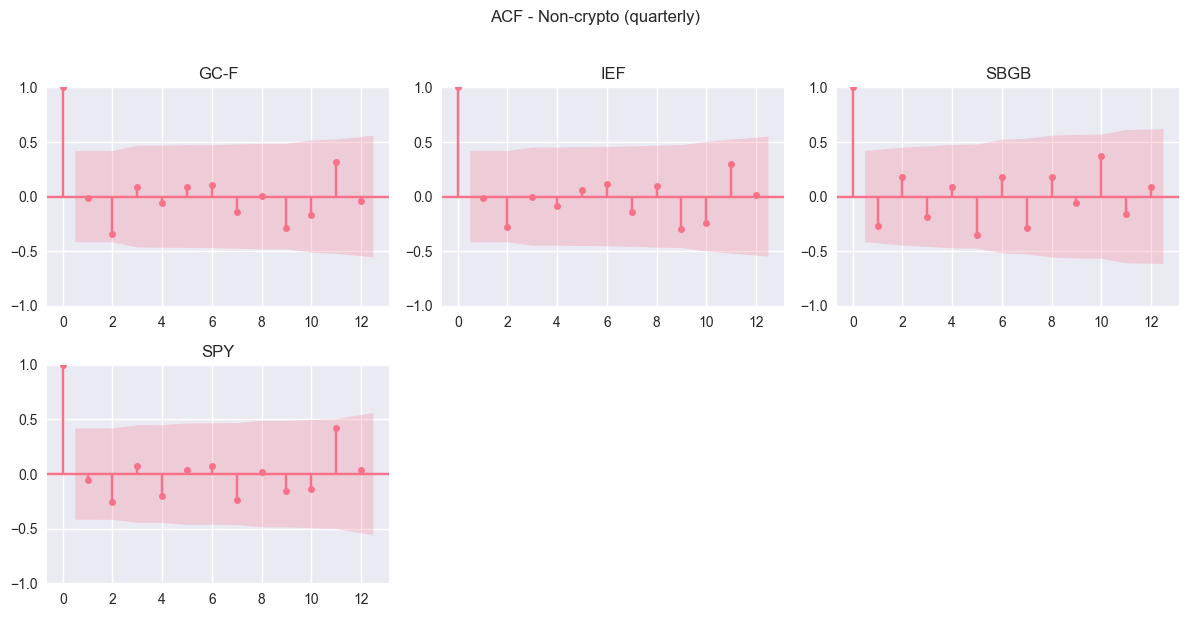

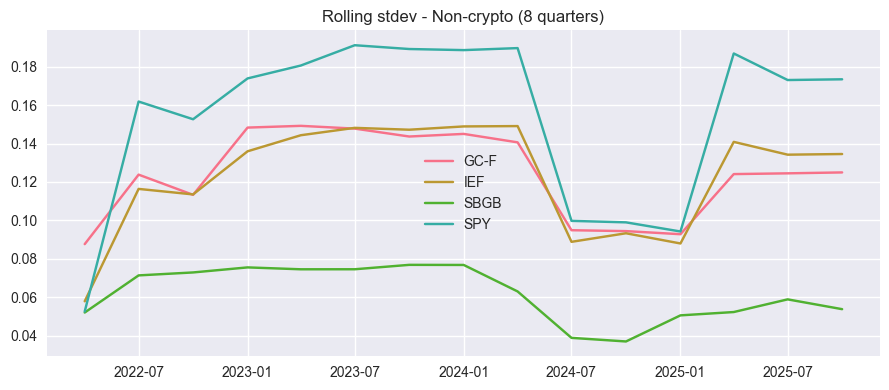

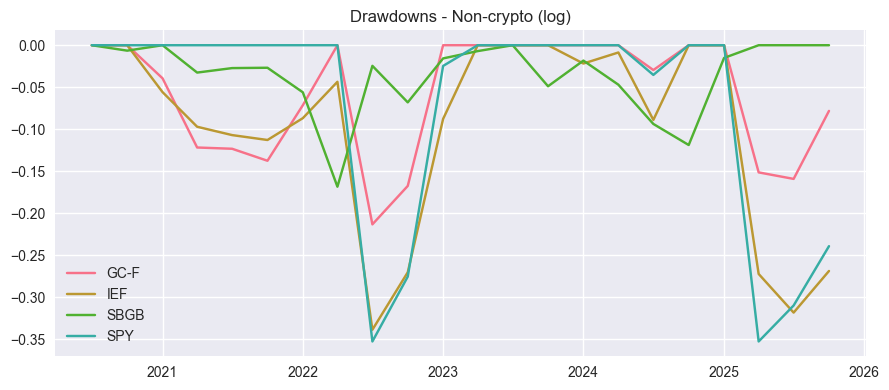

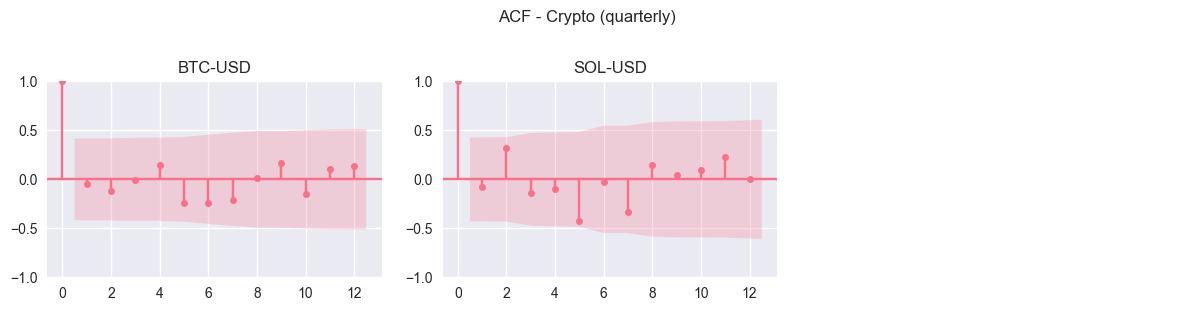

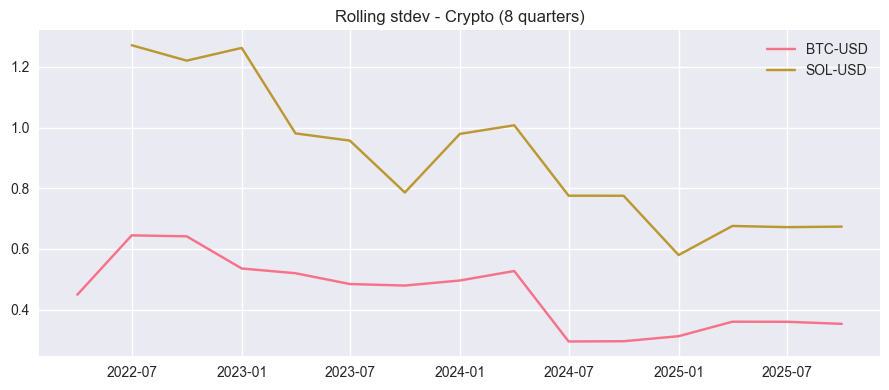

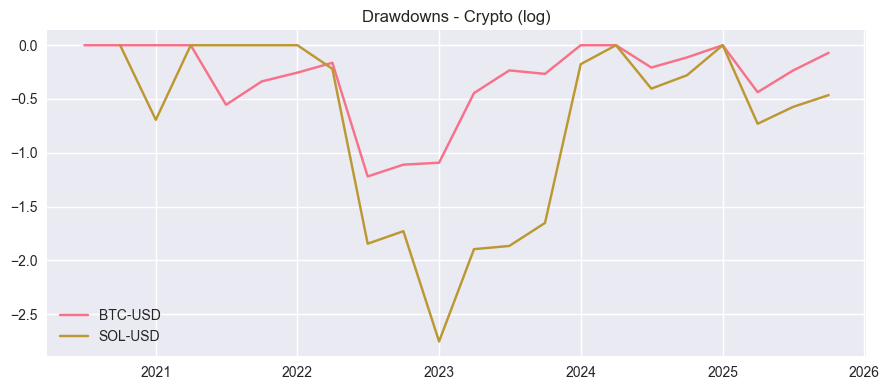

lags,4,8
asset_id,,
BTC-USD,0.901861,0.625653
GC-F,0.482801,0.774314
IEF,0.677733,0.860805
SBGB,0.415738,0.112743
SOL-USD,0.464075,0.087884
SPY,0.522946,0.707041


In [9]:
crypto_cols, noncrypto_cols = split_crypto_noncrypto(list(q_matrix_log.columns))

if noncrypto_cols:
    plot_acf_grid(q_matrix_log[noncrypto_cols], max_lags=12, title='ACF - Non-crypto (quarterly)')
    plot_rolling_stats(q_matrix_log[noncrypto_cols], window=8, title='Rolling stdev - Non-crypto (8 quarters)')
    plot_drawdowns(q_matrix_log[noncrypto_cols], title='Drawdowns - Non-crypto (log)')

if crypto_cols:
    plot_acf_grid(q_matrix_log[crypto_cols], max_lags=12, title='ACF - Crypto (quarterly)')
    plot_rolling_stats(q_matrix_log[crypto_cols], window=8, title='Rolling stdev - Crypto (8 quarters)')
    plot_drawdowns(q_matrix_log[crypto_cols], title='Drawdowns - Crypto (log)')

lb_rows = []
for asset in q_matrix_log.columns:
    lb = ljung_box(q_matrix_log[asset], lags=[4, 8])
    lb['asset_id'] = asset
    lb_rows.append(lb)

lb_table = (
    pd.concat(lb_rows)
    .reset_index()
    .rename(columns={'index': 'lags', 'lb_stat': 'stat', 'lb_pvalue': 'pvalue'})
)

pivot_lb = lb_table.pivot_table(index='asset_id', columns='lags', values='pvalue')
display(styled_table(pivot_lb.sort_index(axis=1), caption='Ljung-Box p-values (quarterly log returns)', precision=3))



## FX Decomposition

In [10]:
fx_breakdown = []
for asset in FOCUS_TICKERS:
    subset = returns_aligned[returns_aligned['asset_id'] == asset].dropna(subset=['r_local_log', 'r_fx_log', 'r_base_log'])
    if len(subset) < 4:
        continue
    var_base = subset['r_base_log'].var(ddof=1)
    var_local = subset['r_local_log'].var(ddof=1)
    var_fx = subset['r_fx_log'].var(ddof=1)
    cov_local_fx = subset['r_local_log'].cov(subset['r_fx_log'])
    formula = var_local + var_fx + 2 * cov_local_fx
    fx_breakdown.append({
        'asset_id': asset,
        'var_base': var_base,
        'var_local': var_local,
        'var_fx': var_fx,
        '2cov_local_fx': 2 * cov_local_fx,
        'formula_minus_base': formula - var_base,
        'fx_var_share': (var_fx / var_base) if pd.notna(var_base) and var_base != 0 else np.nan,
    })

fx_breakdown_df = pd.DataFrame(fx_breakdown).set_index('asset_id')
display(styled_table(
    fx_breakdown_df,
    caption='Variance decomposition: Var(base) = Var(local) + Var(FX) + 2·Cov(local, FX)',
    precision=5,
))

print(
    'Variance equality is shown above; small residuals in formula_minus_base are numerical rounding artefacts.'
)
print(
    'fx_var_share highlights how much of the base-currency variance originates from the currency leg.'
)



C:\Users\koles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\koles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,corr_local_fx,fx_var_share,fx_vol_quarter
asset_id,,,
GC-F,-0.028,0.858,0.157
BTC-USD,0.364,0.107,0.157
SOL-USD,0.222,0.027,0.157
SPY,0.366,0.620,0.157
IEF,-0.166,1.023,0.157
SBGB,NaN,0.000,0.000


## Takeaways

- Quarterly alignment happens upstream in helpers, so the notebook stays narrative-first.
- USD legs still carry the bulk of variance; domestic SBGB anchors the panel.
- FX variance decomposition clarifies how the currency leg feeds base-risk, while diagnostics flag where fat tails and autocorr live.

